# Initial Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np
from PIL import Image

%matplotlib inline

np.random.seed(0)

In [2]:
# raw data location
data_path = 'visapy_data.npy'

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(3)
torch.manual_seed(0)

In [4]:
import cv2
import copy

# Spike Detection

In [5]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

H.DetectFromRaw()
H.LoadDetected()

File size: 122400102
Number of channels: 102
# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059

# Loading and Setting up Ground Truths

## Waveforms

In [6]:
data = np.load('visapy_data.npy')

In [7]:
frame_set = data.reshape((1200001,102))
print("Frame shape: ", frame_set.shape)
print("Whole Dataset: ", frame_set)

Frame shape:  (1200001, 102)
Whole Dataset:  [[  4 -18   3 ...   5 -11  -4]
 [  3 -26  -4 ...   6 -13   6]
 [  3 -25  -6 ...   5 -18   3]
 ...
 [  1  32  -5 ...   7   2   0]
 [-17  27  -9 ...  12  -1  11]
 [-13  21  -8 ...  15   0  10]]


## Ground Truths

In [8]:
somapos = np.loadtxt('ViSAPy_somapos.gdf')
ground_truth = np.loadtxt('ViSAPy_ground_truth.gdf')

ground_truth = ground_truth.astype(int)
somapos = np.array([somapos[:,0], somapos[:,1]])

print(ground_truth.shape)
print(somapos.shape)

(64441, 2)
(2, 56)


## Generate Channel Time Combinations

In [9]:
list_times = H.spikes['t'].tolist()
list_ch = H.spikes['ch'].tolist()

x = H.spikes['x'].tolist()
y = H.spikes['y'].tolist()

print(len(x), len(list_times))

# A list of all time and channel combinations which have spikes
list_times_ch = []
for i in range(len(list_times)):
    list_times_ch.append((list_times[i], list_ch[i]))

19341 19341


## Electrode Positions

In [10]:
x_path = 'z_integer.npy'
y_path = 'y_integer.npy'
elec_x_int = np.load(x_path)
elec_y_int = np.load(y_path)

In [11]:
ky = 9 / np.max(np.diff(sorted(elec_y_int)))
elec_x = elec_x_int * ky
elec_y = elec_y_int * ky
elec_x -= np.min(elec_x)
elec_y -= np.min(elec_y)

In [12]:
datapoints = []
for i in range(len(elec_x)):
    datapoints.append([elec_x[i], elec_y[i]])
datapoints = np.asarray(datapoints)
print(datapoints)

[[ 59.54058193 179.98346095]
 [  0.         233.97886677]
 [ 74.42572741 242.97794793]
 [ 59.54058193  17.99816233]
 [ 29.77029096  35.99632466]
 [ 59.54058193 143.98621746]
 [ 44.65543645 242.97794793]
 [ 14.88514548 296.97243492]
 [ 74.42572741  44.99540582]
 [  0.         107.9898928 ]
 [ 29.77029096 143.98621746]
 [  0.          17.99816233]
 [ 59.54058193  53.99448698]
 [ 44.65543645  80.99264931]
 [ 74.42572741 170.98437979]
 [ 44.65543645 206.98070444]
 [  0.         197.98162328]
 [ 14.88514548 278.97427259]
 [ 44.65543645 296.97243492]
 [ 14.88514548  44.99540582]
 [ 59.54058193  89.99173047]
 [  0.         215.9797856 ]
 [ 74.42572741 278.97427259]
 [ 14.88514548  26.99724349]
 [ 44.65543645  44.99540582]
 [ 44.65543645  98.99081164]
 [ 74.42572741 152.98621746]
 [ 29.77029096   0.        ]
 [ 74.42572741  26.99724349]
 [  0.          53.99448698]
 [ 44.65543645 134.98713629]
 [ 44.65543645  62.99356815]
 [ 59.54058193 287.97335375]
 [ 59.54058193 215.9797856 ]
 [ 59.54058193

In [36]:
location = {}

x = H.spikes['x'].tolist()
y = H.spikes['y'].tolist()

for i in range(len(list_times)):
    location[(list_times[i], list_ch[i])] = (x[i], y[i])

# Generate Images - ONLY USE FIRST TIME!

# Loading Images

In [13]:
# Creates a correspondence between HS2 and Ground Truth

new_list_times_ch = []
new_location = {}
neuron_channels = {}

for i, val in enumerate(list_times_ch):
    for ind, j in enumerate(ground_truth[:, 1]):
        if val[0] in range(j-2, j+2):
            neuron = ground_truth[ind, 0] - 1
            new_list_times_ch.append((val[0], val[1]))
            new_location[(val[0], val[1])] = (somapos[0, neuron], somapos[1, neuron])
            try:
                neuron_channels[neuron].append((val[0], val[1]))
            except:
                neuron_channels[neuron] = [(val[0], val[1])]
            break

In [14]:
image_data = {}

for i in range(len(new_list_times_ch)):
    filename = "frames_small_attention/frame_"+str(new_list_times_ch[i][0])+"_"+str(new_list_times_ch[i][1])+".png"
    temp_pic = cv2.imread(filename)
    temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
    temp_pic = temp_pic/255
    image_data[(new_list_times_ch[i][0], new_list_times_ch[i][1])] = temp_pic

# Removing False Triggers from Neuron List

In [15]:
# Filter only relevant frames
from collections import Counter

updated_neuron_channels = {}
for i in neuron_channels.keys():
    updated_neuron_channels[i] = []
    elec_list = np.array(neuron_channels[i])[:, 1]
    occ = Counter(elec_list)
    final_elec_list = []
    for d in occ.keys():
        if occ[d] > 80:
            final_elec_list.append(d)
    for j in final_elec_list:
        for k in neuron_channels[i]:
            if k[1] == j:
                updated_neuron_channels[i].append(k)

In [16]:
# New list of times and channels

list_loc_ch = []
for i in updated_neuron_channels.values():
    list_loc_ch = list_loc_ch + i
print(len(list_loc_ch))

8977


In [17]:
import random

random.seed(0)
random.shuffle(list_loc_ch)

train_lim = (int)(0.75*len(list_loc_ch))
val_lim = (int)(0.80*len(list_loc_ch))

list_times_ch_train = list_loc_ch[:train_lim]
list_times_ch_val = list_loc_ch[train_lim:val_lim]
list_times_ch_test = list_loc_ch[val_lim:]

print(len(list_times_ch_train),len(list_times_ch_val), len(list_times_ch_test))

6732 449 1796


In [28]:
# No of examples for each neuron
for i in updated_neuron_channels.keys():
    if len(updated_neuron_channels[i]) != 0:
        print(i, '-', len(updated_neuron_channels[i]), end = ', ')

46 - 775, 41 - 631, 12 - 543, 49 - 398, 27 - 497, 43 - 576, 28 - 276, 53 - 406, 22 - 306, 21 - 213, 10 - 507, 34 - 529, 11 - 307, 48 - 311, 47 - 179, 18 - 338, 38 - 277, 32 - 207, 13 - 436, 42 - 434, 40 - 302, 37 - 280, 8 - 128, 15 - 121, 

In [30]:
# Channels associated to each neuron
for i in updated_neuron_channels.keys():
    list_oc = []
    for j in updated_neuron_channels[i]:
        list_oc.append(j[1])
    print(i, '-', set(list_oc), end = ', ')

46 - {48, 58}, 41 - {81, 65, 84}, 12 - {68}, 49 - {17}, 27 - {72, 26}, 43 - {95}, 45 - set(), 28 - {60}, 52 - set(), 53 - {18, 7}, 22 - {97, 98}, 21 - {46}, 10 - {93}, 34 - {66, 37}, 5 - set(), 35 - set(), 11 - {96, 28}, 50 - set(), 48 - {57}, 47 - {58}, 54 - set(), 18 - {13}, 38 - {33}, 9 - set(), 32 - {71}, 13 - {35}, 42 - {84, 53}, 1 - set(), 40 - {1}, 31 - set(), 37 - {41}, 29 - set(), 2 - set(), 39 - set(), 55 - set(), 24 - set(), 17 - set(), 0 - set(), 6 - set(), 8 - {11}, 26 - set(), 7 - set(), 23 - set(), 36 - set(), 14 - set(), 3 - set(), 51 - set(), 25 - set(), 30 - set(), 15 - {62}, 19 - set(), 33 - set(), 44 - set(), 20 - set(), 16 - set(), 4 - set(), 

# Defining the CNN

In [31]:
#torch.cuda.set_device(1)

class LocatorCNN(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.2) #0.1
        self.drop1 = nn.Dropout(p=0.5) #0.05
        
        self.activation_layer_2d = nn.ReLU()
        self.activation_layer = nn.ELU()
        
        #self.linear_0 = nn.Linear(107648, 4096)
        self.linear_1 = nn.Linear(2304, 1024) #with maxpooling
        #self.linear_1 = nn.Linear(9750528, 2048)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 128)
        self.linear_4 = nn.Linear(128, 32)
        self.linear_5 = nn.Linear(33, 8)
        self.linear_6 = nn.Linear(8, 2)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer2(out)
        #print(out.shape)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        #out = self.drop2(out)
        #print(out.shape)
        
        out = out.view(dim, -1)
        #out = self.linear_0(out)
        #out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        #print(out.shape, channel.shape)
        out = torch.cat((out, channel), dim=1)
        out = self.linear_5(out)
        out = self.activation_layer(out)
        out = self.linear_6(out)
        
        return out

In [32]:
cnn_1 = torch.load('models/cnn_models/loc_cnn_unbranched.pt', map_location=lambda storage, loc: storage)

In [40]:
#Executing the CNN

x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
x = torch.from_numpy(x).float()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float()
out = (out.data).cpu().numpy()

# Median of results for neurons

In [47]:
cnn_loc = []
com_loc = []
true_loc = []

# Use 12, 27, 43, 28, 53

for i, val in enumerate(updated_neuron_channels[53]):
    for j, index in enumerate(list_times_ch_test):
        if val == index:
            com_loc.append(location[val])
            cnn_loc.append(out[j])
            true_loc.append(new_location[val])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)
true_loc = np.array(true_loc)
#print(cnn_loc)
#print(com_loc)
print("True Location: ", true_loc[0, :])

print("CNN: ", np.median(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.median(com_loc, axis=0), np.var(com_loc, axis=0))

True Location:  [ 29.19640478 304.72127251]
CNN:  [ 28.262249 303.6813  ] [ 5.3694634 60.307655 ]
COM:  [ 30.377 287.02 ] [12.59309593  2.40858844]


# Plotting Outputs

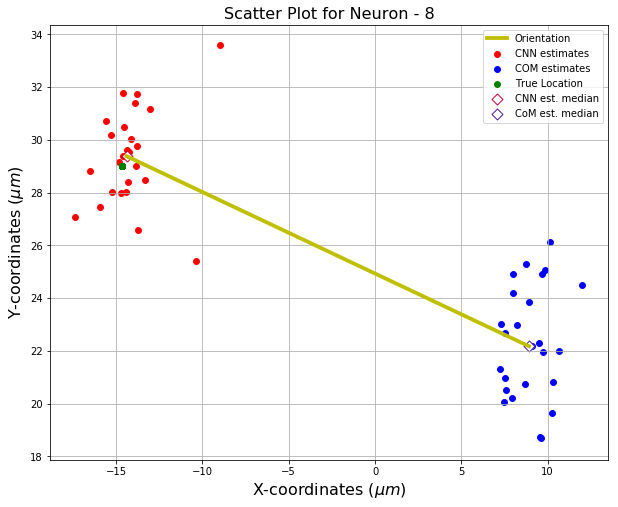

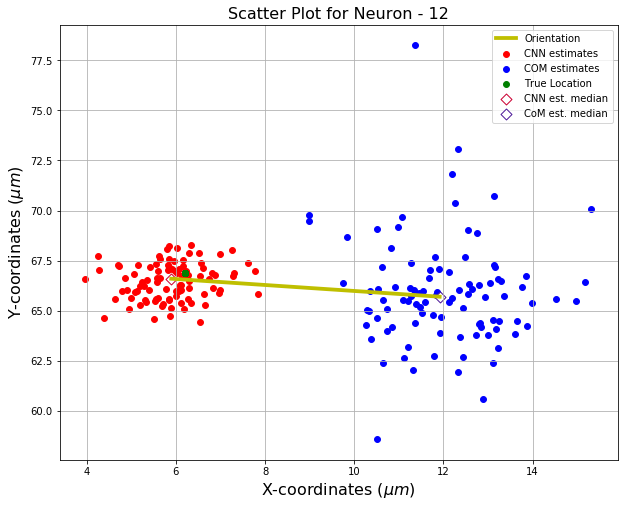

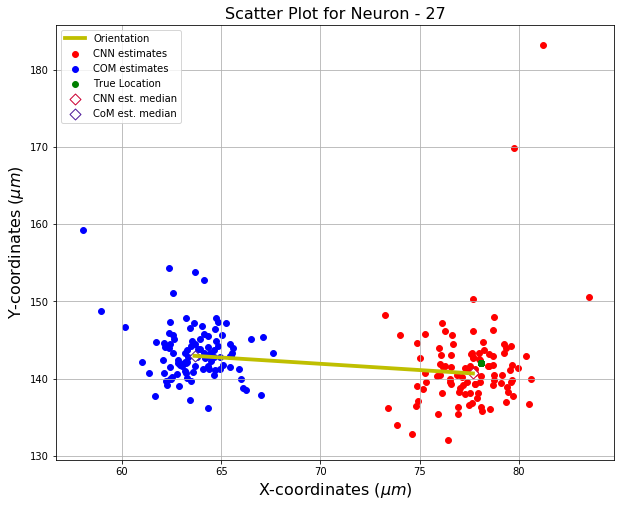

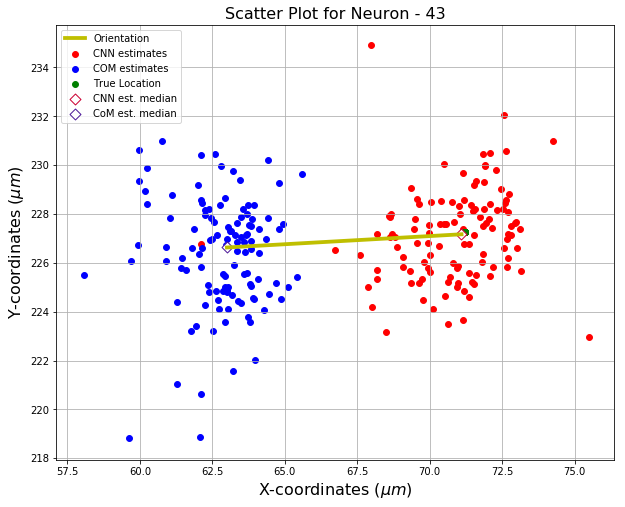

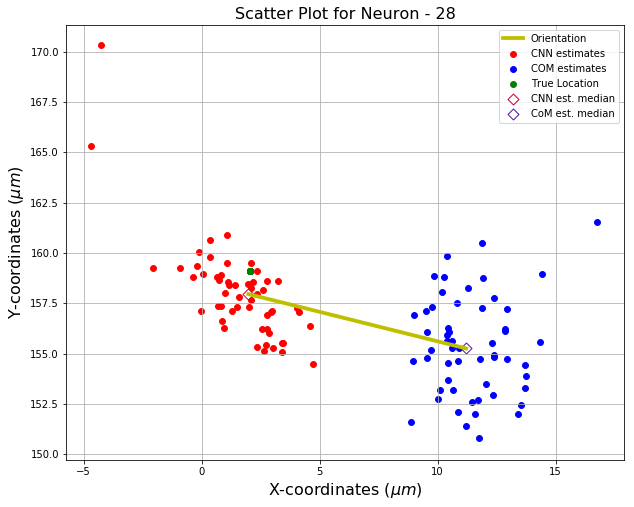

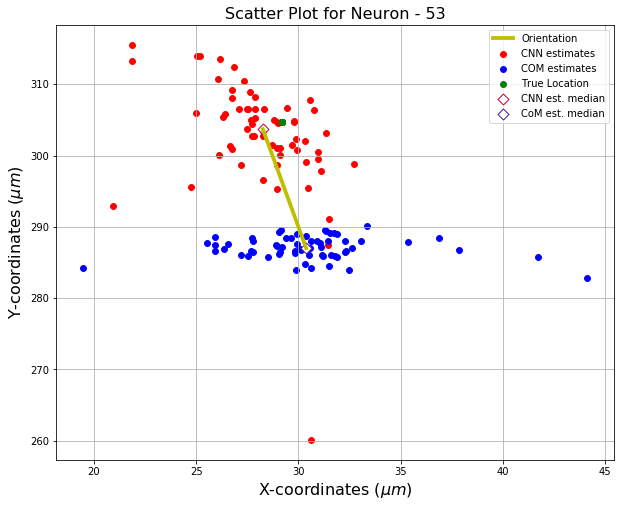

In [71]:
# remove the plt.plot lineif you do not want to see orientations
for looper in [8, 12, 27, 43, 28, 53]:
    cnn_loc = []
    com_loc = []
    true_loc = []

    for i, val in enumerate(updated_neuron_channels[looper]):
        for j, index in enumerate(list_times_ch_test):
            if val == index:
                com_loc.append(location[val])
                cnn_loc.append(out[j])
                true_loc.append(new_location[val])
    cnn_loc = np.array(cnn_loc)
    com_loc = np.array(com_loc)
    true_loc = np.array(true_loc)
    #print(cnn_loc)
    #print(com_loc)
    
    #print("True Location: ", true_loc[0, :])
    #print("CNN: ", np.median(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
    #print("COM: ", np.median(com_loc, axis=0), np.var(com_loc, axis=0))
    cnn_median = np.median(cnn_loc, axis=0)
    com_median = np.median(com_loc, axis=0)

    fig = plt.figure(figsize=(10,8))
    plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r', s=35, label='CNN estimates')
    plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b', s=35, label='COM estimates')
    plt.scatter(true_loc[:, 0], true_loc[:, 1], c = 'g', s=35, label='True Location')
    plt.scatter(cnn_median[0], cnn_median[1], facecolors='white', edgecolors=(0.8, 0, 0.2), s=60, marker="D", label='CNN est. median')
    plt.scatter(com_median[0], com_median[1], facecolors='white', edgecolors=(0.3, 0.1, 0.6), s=60, marker="D", label='CoM est. median')
    plt.plot([cnn_median[0], com_median[0]], [cnn_median[1], com_median[1]], 'y', label='Orientation',  linewidth=3.8)
    plt.xlabel(u'X-coordinates (${\mu}m$)', fontsize=16)
    plt.ylabel(u'Y-coordinates (${\mu}m$)', fontsize=16)
    plt.legend()
    plt.title('Scatter Plot for Neuron - '+str(looper), fontsize=16)
    plt.grid()
    plt.show()
    #print(np.median(cnn_loc, axis=0), np.median(com_loc, axis=0))

    fig.savefig("neuron_loc_"+str(looper)+".png", bbox_inches='tight')

# No channel models

In [75]:
#torch.cuda.set_device(1)

class LocatorCNN_NC(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN_NC, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.2) #0.1
        self.drop1 = nn.Dropout(p=0.5) #0.05
        
        self.activation_layer_2d = nn.ReLU()
        self.activation_layer = nn.ELU()
        
        #self.linear_0 = nn.Linear(107648, 4096)
        self.linear_1 = nn.Linear(2304, 1024) #with maxpooling
        #self.linear_1 = nn.Linear(9750528, 2048)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 128)
        self.linear_4 = nn.Linear(128, 32)
        self.linear_5 = nn.Linear(32, 8)
        self.linear_6 = nn.Linear(8, 2)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        out = self.conv_layer2(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        
        out = out.view(dim, -1)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        out = self.linear_5(out)
        out = self.activation_layer(out)
        out = self.linear_6(out)
        
        return out

In [80]:
cnn_1 = torch.load('models/cnn_models/loc_cnn_nochannel.pt', map_location=lambda storage, loc: storage)

In [81]:
#Executing the CNN

x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
x = torch.from_numpy(x).float()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float()
out = (out.data).cpu().numpy()

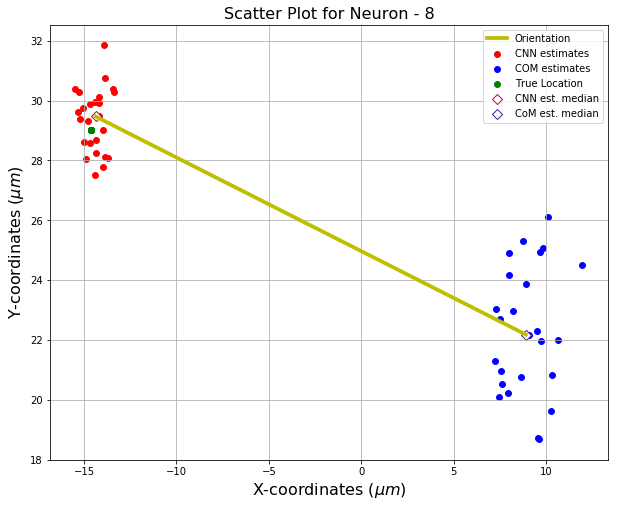

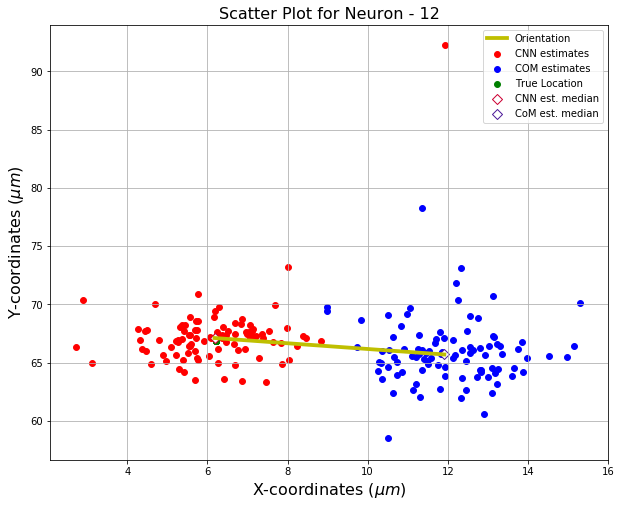

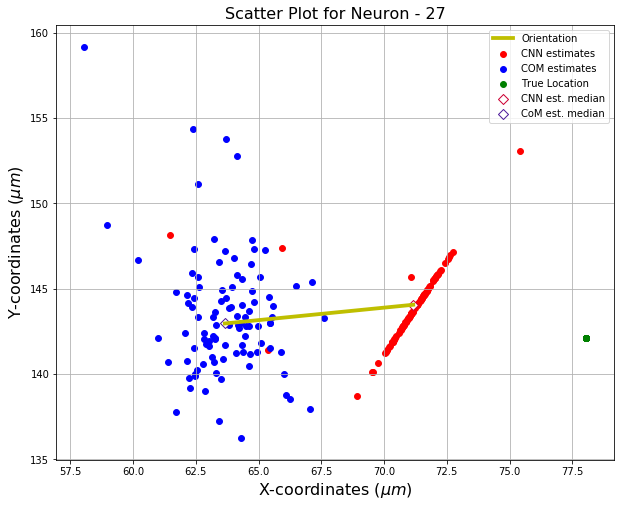

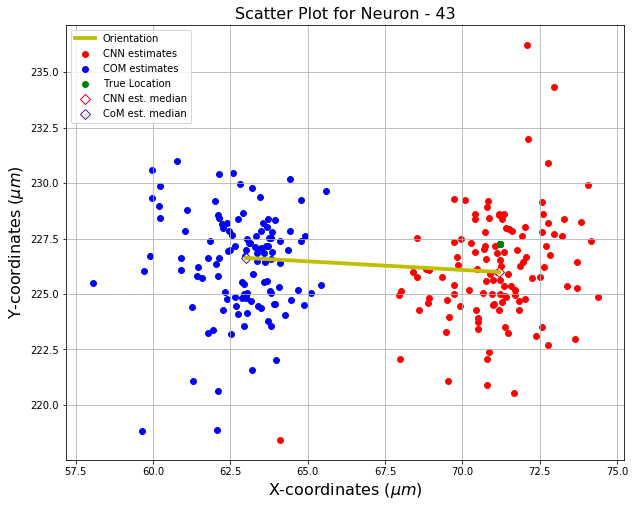

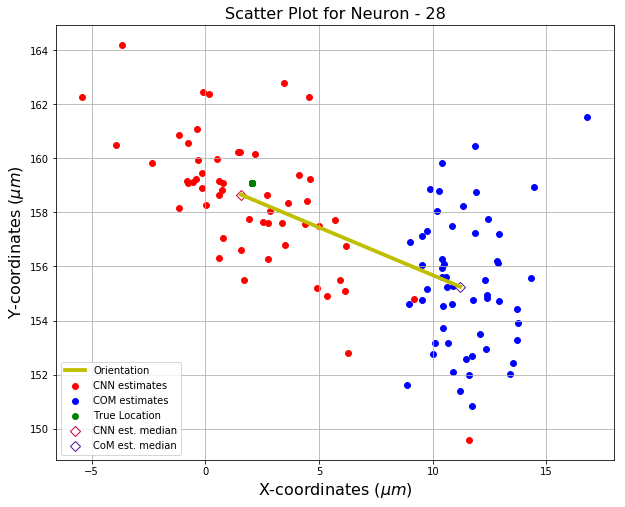

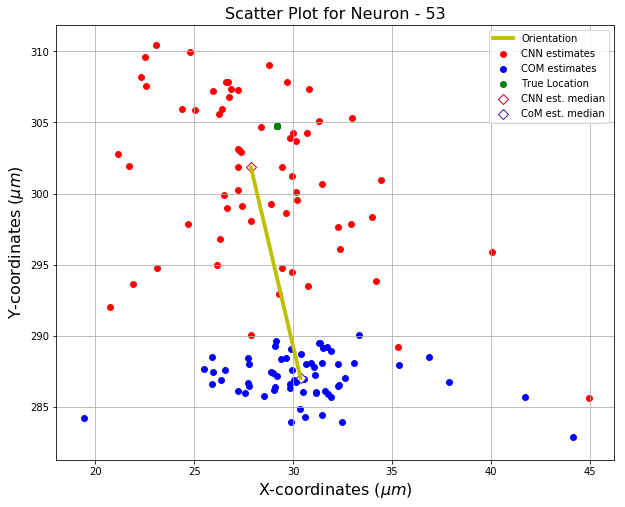

In [85]:
# remove the plt.plot lineif you do not want to see orientations
for looper in [8, 12, 27, 43, 28, 53]:
    cnn_loc = []
    com_loc = []
    true_loc = []

    for i, val in enumerate(updated_neuron_channels[looper]):
        for j, index in enumerate(list_times_ch_test):
            if val == index:
                com_loc.append(location[val])
                cnn_loc.append(out[j])
                true_loc.append(new_location[val])
    cnn_loc = np.array(cnn_loc)
    com_loc = np.array(com_loc)
    true_loc = np.array(true_loc)
    #print(cnn_loc)
    #print(com_loc)
    
    #print("True Location: ", true_loc[0, :])
    #print("CNN: ", np.median(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
    #print("COM: ", np.median(com_loc, axis=0), np.var(com_loc, axis=0))
    cnn_median = np.median(cnn_loc, axis=0)
    com_median = np.median(com_loc, axis=0)

    fig = plt.figure(figsize=(10,8))
    plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r', s=35, label='CNN estimates')
    plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b', s=35, label='COM estimates')
    plt.scatter(true_loc[:, 0], true_loc[:, 1], c = 'g', s=35, label='True Location')
    plt.scatter(cnn_median[0], cnn_median[1], facecolors='white', edgecolors=(0.8, 0, 0.2), s=50, marker="D", label='CNN est. median')
    plt.scatter(com_median[0], com_median[1], facecolors='white', edgecolors=(0.3, 0.1, 0.6), s=50, marker="D", label='CoM est. median')
    plt.plot([cnn_median[0], com_median[0]], [cnn_median[1], com_median[1]], 'y', label='Orientation',  linewidth=3.8)
    plt.xlabel(u'X-coordinates (${\mu}m$)', fontsize=16)
    plt.ylabel(u'Y-coordinates (${\mu}m$)', fontsize=16)
    plt.legend()
    plt.title('Scatter Plot for Neuron - '+str(looper), fontsize=16)
    plt.grid()
    plt.show()
    #print(np.median(cnn_loc, axis=0), np.median(com_loc, axis=0))

    #fig.savefig("neuron_loc_"+str(looper)+".png", bbox_inches='tight')

# IF you need to train models

In [ ]:
import random
random.seed(0)

def train_cnn(model, times_ch_tr, times_ch_v, images, location, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, len(times_ch_tr)), batch_size)
        x = np.zeros((batch_size, 54, 54))
        ch = np.zeros((batch_size, 1))
        loc = np.zeros((batch_size, 2))
        for i in range(len(selected)):
            pointer = times_ch_tr[i]
            x[i, :, :] = images[pointer]
            ch[i, :] = np.array(pointer[1])
            loc[i, :] = np.array(location[pointer])
        dim = batch_size
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, 54, 54)
        ch = torch.from_numpy(ch).float().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim, ch)
        out = torch.tensor(out).float().cuda()
        loc = torch.from_numpy(loc).float().cuda()
        loss = criterion(out, loc)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, len(times_ch_v)), 30)
        v_im = np.zeros((30, 54, 54))
        v_ch = np.zeros((30, 1))
        v_loc = np.zeros((30, 2))
        for i in range(len(v)):
            pointer = times_ch_v[i]
            v_im[i, :, :] = images[pointer]
            dim = v_im.shape[0]
            v_ch[i, :] = np.array(pointer[1])
            v_loc[i, :] = np.array(location[pointer])
        
        v_im = torch.from_numpy(v_im).float().cuda()
        v_im = v_im.view(30, -1, 54, 54)
        v_ch = torch.from_numpy(v_ch).float().cuda()
        v_loc = torch.from_numpy(v_loc).float().cuda()
        
        
        val_out = model.forward(v_im, 30, v_ch)
        v_loss = criterion(val_out, v_loc)
        
        val_losses.append(v_loss.data[0])            
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], v_loss.data[0]))
    return out, losses, val_losses

def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [ ]:
epoch_range = 10000
batch_size = 300
learning_rate = 0.0001

cnn_1 = LocatorCNN_NC().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate, weight_decay=0.001)

out, losses_1, vloss = train_cnn(cnn_1, list_times_ch_train, list_times_ch_val ,image_data, new_location, criterion, optimizer, epoch_range, batch_size)

In [ ]:
torch.save(cnn_1, 'models/cnn_models/loc_cnn_new.pt') #Saving the autoencoder model